In [2]:
!pip install transformers==3.0.0

In [3]:
import random
import os
import re
import math
import time
import datetime
import numpy as np
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
os.environ['PYTHONHASHSEED'] = str(seed_val)
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split,learning_curve, GridSearchCV, cross_val_score, StratifiedKFold,StratifiedShuffleSplit
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import torch
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import transformers as tf
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast,BertModel
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
%matplotlib inline

from google.colab import drive
from google.colab import files

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dev_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Train.csv')
dev_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Test.csv')
test_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Train.csv')
test_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Test.csv')

In [7]:
dev_train['label'] = dev_train.label.map({'L':0, 'I':1})
dev_train['isCanon'] = dev_train.isCanon.map({'Not':0, 'C':1})

In [8]:
dev_test['label'] = dev_test.label.map({'L':0, 'I':1})
dev_test['isCanon'] = dev_test.isCanon.map({'Not':0, 'C':1})

In [9]:
test_train['label'] = test_train.label.map({'L':0, 'I':1})
test_train['isCanon'] = test_train.isCanon.map({'Not':0, 'C':1})

In [10]:
test_test['label'] = test_test.label.map({'L':0, 'I':1})
test_test['isCanon'] = test_test.isCanon.map({'Not':0, 'C':1})

In [11]:
file_name=dev_train.fileName.unique().tolist()
file_name

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
dev_train=test_train
dev_test=test_test

In [13]:
mwe_name=dev_train.mwe.unique().tolist()

In [14]:
mwe_name

['make_mark',
 'make_scene',
 'have_word',
 'blow_whistle',
 'cut_figure',
 'hit_wall',
 'get_wind',
 'make_hay',
 'lose_thread',
 'get_sack',
 'make_hit',
 'pull_punch',
 'hold_fire',
 'blow_top']

In [15]:
dev_all=dev_train.append(dev_test)
dev_all=dev_all[dev_all.fileName==0]

In [16]:
# dev_train=dev_train[dev_train.fileName==0]
# dev_test=dev_test[dev_test.fileName==0]

In [17]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [18]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    return np.sum(preds == labels.numpy()) / len(labels)

def flat_accuracy_num(preds, labels):
    # pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    return np.sum(preds == labels.numpy())

In [19]:
hidden_data=[]
hidden_dat=[]
cls_hs_input=[]
class Classifier(nn.Module):

    def __init__(self, bert):

        super(Classifier, self).__init__()
        
        # self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.roberta = RobertaModel.from_pretrained('roberta-base',output_hidden_states=True)
        
        self.dropout = nn.Dropout(0.5)
        
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(769,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask,i,data_loader,t):

        #pass the inputs to the model  
        # _, cls_hs = self.roberta(input_ids=sent_id, attention_mask=mask)
        outputs= self.roberta(input_ids=sent_id, attention_mask=mask)
        # cls_hs=output[0][:,0,:]
        outputs = outputs[2]
        cls_hs=outputs[-1][:,0,:]

        if t=='training':
            # print("training:")
            # print(i,data_loader,batch_size,len(train_data),len(CF_arr))
            if i<(data_loader-1):
                cls_hs=torch.cat((cls_hs,CF_arr[int(batch_size*i):int(batch_size*(i+1))]),1)

            else:
                cls_hs=torch.cat((cls_hs,CF_arr[int(batch_size*i):len(train_data)]),1)
        elif t=='validation':
            # print("validating:")
            # print(i,data_loader,batch_size,len(val_data),len(CF_arr))
            if i<(data_loader-1):
                cls_hs=torch.cat((cls_hs,CF_arr[len(train_data)+int(batch_size*i):len(train_data)+int(batch_size*(i+1))]),1)

            else:
                cls_hs=torch.cat((cls_hs,CF_arr[len(train_data)+int(batch_size*i):len(dev_train['sentence'])]),1)
        elif t=='testing':
            # print("testing:")
            cls_hs=torch.cat((cls_hs,CF_test_arr[0:len(test_seq)]),1)

        if t=='testing':
            cls_hs_input.append(cls_hs.detach().cpu().numpy())
        x = self.fc1(cls_hs)
        if t=='testing':
            hidden_dat.append(x.detach().cpu().numpy())
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        if t=='testing':
            hidden_data.append(x.detach().cpu().numpy())
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [20]:
# function to train the model
def train():
  
  model.train()
  i=0
  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # print(i)
    # progress update after every 50 batches.
    if step % 10 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask,i,len(train_dataloader),'training')

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # scheduler = get_linear_schedule_with_warmup(optimizer, 
    #                                                     num_warmup_steps = 0, # Default value in run_glue.py
    #                                                     num_training_steps = total_steps)
    # update parameters
    optimizer.step()
    # scheduler.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    i+=1
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()
  i=0  
  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    # print(i)
    # Progress update every 50 batches.
    if step % 10 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
    #   print("val_loop:",i)
      # model predictions
      preds = model(sent_id, mask,i,len(val_dataloader),'validation')

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)
    i+=1
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [22]:
###################################################################################
#####################################all together###################################
##################################################################################
temp_train=pd.DataFrame()
temp_validation=pd.DataFrame()
train_loss=[]
lr_clf_scores_dict={}
svc_clf_scores_dict={}
avg_acc=[]
val_result = []
# learning_rate_range=[2e-5,3e-5,5e-5]
# epoch_range=[2,3,4]
# batch_size_range=[8,16,32]
learning_rate_range=[2e-5]
epoch_range=[3]
batch_size_range=[8]
i=0
run=0
final_result_df=pd.DataFrame()
final_result_df_le=pd.DataFrame()
random_seeds=[68,96,20,53,91,72,42,14,24,67]
random_seeds=[72]
for rand_var in random_seeds:
    for er in epoch_range:
        for lrr in learning_rate_range:
          for bsr in batch_size_range:
            for ds in mwe_name:
                print(str(run))
                print("------------------------------------------------------------")
                run+=1
                print("Start processing for: ",ds)
                temp_train = dev_all[~(dev_all.mwe == ds)]
                temp_test=dev_all[(dev_all.mwe == ds)]

                seed_value = rand_var
                # random.seed(seed_val)
                # np.random.seed(seed_val)
                # torch.manual_seed(seed_val)
                # torch.cuda.manual_seed_all(seed_val)
                import os
                os.environ['PYTHONHASHSEED']=str(seed_value)
                # 2. Set `python` built-in pseudo-random generator at a fixed value
                import random
                random.seed(seed_value)
                # 3. Set `numpy` pseudo-random generator at a fixed value
                import numpy as np
                np.random.seed(seed_value)
                import torch
                torch.manual_seed(seed_value)
                torch.cuda.manual_seed_all(seed_value)
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False

                # roberta = RobertaModel.from_pretrained('roberta-base')
                roberta = RobertaModel.from_pretrained('roberta-base',output_hidden_states=True)
                # Load the RoBERTa tokenizer
                tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
                # get length of all the messages in the train set
                seq_len = [len(i.split()) for i in dev_train['sentence']]
                # pd.Series(seq_len).hist(bins = 30)
                max_seq_len = 0
                max_len = max_seq_len
                # For every sentence...
                for sent in temp_train['sentence']:
                    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
                    train_input_ids = tokenizer.encode(sent, add_special_tokens=True)
                    # Update the maximum sentence length.
                    max_seq_len = max(max_seq_len, len(train_input_ids))
                train_text, val_text, train_labels, val_labels = train_test_split(temp_train['sentence'], temp_train['label'], 
                                                                        random_state=2018, 
                                                                        test_size=0.2, 
                                                                        stratify=temp_train['label'])

                # we will use temp_text and temp_labels to create validation and test set
                test_text =temp_test['sentence']
                test_labels =temp_test['label']
                # tokenize and encode sequences in the training set
                tokens_train = tokenizer.batch_encode_plus(
                    train_text.tolist(),
                    max_length = max_seq_len,
                    pad_to_max_length=True,
                    truncation=True,
                    return_token_type_ids=False
                )

                # tokenize and encode sequences in the validation set
                tokens_val = tokenizer.batch_encode_plus(
                    val_text.tolist(),
                    max_length = max_seq_len,
                    pad_to_max_length=True,
                    truncation=True,
                    return_token_type_ids=False
                )

                # tokenize and encode sequences in the test set
                tokens_test = tokenizer.batch_encode_plus(
                    test_text.tolist(),
                    max_length = max_seq_len,
                    pad_to_max_length=True,
                    truncation=True,
                    return_token_type_ids=False
                )
                # for train set
                train_seq = torch.tensor(tokens_train['input_ids'])
                train_mask = torch.tensor(tokens_train['attention_mask'])
                train_y = torch.tensor(train_labels.tolist())

                # for validation set
                val_seq = torch.tensor(tokens_val['input_ids'])
                val_mask = torch.tensor(tokens_val['attention_mask'])
                val_y = torch.tensor(val_labels.tolist())

                # for test set
                test_seq = torch.tensor(tokens_test['input_ids'])
                test_mask = torch.tensor(tokens_test['attention_mask'])
                test_y = torch.tensor(test_labels.tolist())

                #define a batch size
                batch_size = bsr
                # batch_size = 32

                # wrap tensors
                train_data = TensorDataset(train_seq, train_mask, train_y)

                # sampler for sampling the data during training
                train_sampler = RandomSampler(train_data)

                # dataLoader for train set
                train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

                # wrap tensors
                val_data = TensorDataset(val_seq, val_mask, val_y)

                # sampler for sampling the data during training
                val_sampler = SequentialSampler(val_data)

                # dataLoader for validation set
                val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                CF_arr=torch.tensor(temp_train.isCanon.to_numpy())
                CF_arr=torch.reshape(CF_arr,(-1,1))
                CF_arr=CF_arr.to(device)
                CF_test_arr=torch.tensor(temp_test.isCanon.to_numpy())
                CF_test_arr=torch.reshape(CF_test_arr,(-1,1))
                CF_test_arr=CF_arr.to(device)

                training_stats = []
                training_stats_le = []
                # pass the pre-trained BERT to our define architecture
                model = Classifier(roberta)

                # push the model to GPU
                model = model.to(device)
                # optimizer from hugging face transformer
                # define the optimizer
                optimizer = AdamW(model.parameters(), lr = lrr)

                #compute the class weights
                class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
                # convert class weights to tensor
                weights= torch.tensor(class_wts,dtype=torch.float)
                weights = weights.to(device)

                # loss function
                cross_entropy  = nn.NLLLoss(weight=weights) 

                # number of training epochs
                epochs = er
                # set initial loss to infinite
                best_valid_loss = float('inf')

                # empty lists to store training and validation loss of each epoch
                train_losses=[]
                valid_losses=[]

                #for each epoch
                for epoch in range(epochs):
                    
                    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
                    
                    #train model
                    train_loss, _ = train()
                    
                    #evaluate model
                    valid_loss, _ = evaluate()
                    
                    #save the best model
                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        torch.save(model.state_dict(), 'saved_weights.pt')
                    
                    # append training and validation loss
                    train_losses.append(train_loss)
                    valid_losses.append(valid_loss)
                    
                    print(f'\nTraining Loss: {train_loss:.3f}')
                    print(f'Validation Loss: {valid_loss:.3f}')
                    
                # get predictions for test data
                with torch.no_grad():
                    preds = model(test_seq.to(device), test_mask.to(device),0,0,'testing')
                    preds = preds.detach().cpu().numpy()
                # model's performance
                preds = np.argmax(preds, axis = 1)

                # print(classification_report(test_y, preds))
                total_eval_accuracy_num = 0
                total_eval_accuracy = 0
                total_eval_accuracy = flat_accuracy(preds, test_y)
                total_eval_accuracy_num = flat_accuracy_num(preds, test_y)
                print("Number of True Prediction: {0:10.4f}".format(total_eval_accuracy_num))
                # avg_val_accuracy = total_eval_accuracy / len(test_y)
                print("Accuracy: {0:10.4f}".format(total_eval_accuracy))
                # val_result.append((rand_var,total_eval_accuracy, total_eval_accuracy_num, len(test_y), ds, lrr, er, bsr))
                
                TN = 0
                FN = 0
                TP = 0
                FP = 0       
                CM = confusion_matrix(test_y, preds)
                report= classification_report(test_y, preds, digits=3,output_dict=True)
                df = pd.DataFrame(report).transpose()

                TN = CM[0][0]
                FN = CM[1][0]
                TP = CM[1][1]
                FP = CM[0][1]

                if ((TP+FP) == 0):
                    precision = 0.0
                else:
                    precision=TP/(TP+FP)
                if ((TP+FN) == 0):
                    recall = 0.0
                else:
                    recall=TP/(TP+FN)
                if (precision+recall > 0 ):
                    f1 = (2.0*precision*recall)/(precision+recall)
                else:
                    f1 = 0.0

                precision_0=report['0']['precision']
                recall_0=report['0']['recall']
                f1_0=report['0']['f1-score']
                support_0=report['0']['support']
                precision_1=report['1']['precision']
                recall_1=report['1']['recall']
                f1_1=report['1']['f1-score']
                support_1=report['1']['support']
                macro_avg_f1=report['macro avg']['f1-score']
                macro_avg_precision=report['macro avg']['precision']
                macro_avg_recall=report['macro avg']['recall']
                macro_avg_support=report['macro avg']['support']
                weighted_avg_f1=report['weighted avg']['f1-score']
                weighted_avg_precision=report['weighted avg']['precision']
                weighted_avg_recall=report['weighted avg']['recall']
                weighted_avg_support=report['weighted avg']['support']

                val_result.append((rand_var,total_eval_accuracy, total_eval_accuracy_num, len(test_y),
                                    TN,FN,TP,FP,
                                    precision_0,recall_0,f1_0,support_0,
                                    precision_1,recall_1,f1_1,support_1,
                                    macro_avg_f1,macro_avg_precision,macro_avg_recall,macro_avg_support,
                                    weighted_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_support,
                                    ds, lrr, er, bsr))
                print('DONE.')
validation_df=pd.DataFrame(val_result,columns=['rand_var','accuracy', 'true_labels', 'all_labels',
                                               'TN','FN','TP','FP',
                                                'precision_literal','recall_literal','f1_literal','support_literal',
                                                'precision_idiomatic','recall_idiomatic','f1_idiomatic','support_idiomatic',
                                                'macro_avg_f1','macro_avg_precision','macro_avg_recall','macro_avg_support',
                                                'weighted_avg_f1','weighted_avg_precision','weighted_avg_recall','weighted_avg_support',
                                               'file', 'lr', 'e', 'b'])
                
# validation_df=pd.DataFrame(val_result,columns=['rand_var','accuracy', 'true_labels', 'all_labels','file', 'lr', 'e', 'b'])
validation_df.to_excel('RoBERTa-UE-FT-DCF-CLS-DEV.xlsx',index=False)
files.download('RoBERTa-UE-FT-DCF-CLS-DEV.xlsx')

0
------------------------------------------------------------
Start processing for:  make_mark




 Epoch 1 / 3
  Batch    10  of     53.
  Batch    20  of     53.
  Batch    30  of     53.
  Batch    40  of     53.
  Batch    50  of     53.

Evaluating...
  Batch    10  of     14.

Training Loss: 0.661
Validation Loss: 0.497

 Epoch 2 / 3
  Batch    10  of     53.
  Batch    20  of     53.
  Batch    30  of     53.
  Batch    40  of     53.
  Batch    50  of     53.

Evaluating...
  Batch    10  of     14.

Training Loss: 0.351
Validation Loss: 0.616

 Epoch 3 / 3
  Batch    10  of     53.
  Batch    20  of     53.
  Batch    30  of     53.
  Batch    40  of     53.
  Batch    50  of     53.

Evaluating...
  Batch    10  of     14.

Training Loss: 0.302
Validation Loss: 0.689
Number of True Prediction:    71.0000
Accuracy:     0.8353
DONE.
1
------------------------------------------------------------
Start processing for:  make_scene

 Epoch 1 / 3
  Batch    10  of     57.
  Batch    20  of     57.
  Batch    30  of     57.
  Batch    40  of     57.
  Batch    50  of     57.

Ev

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
dev_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Train.csv')
dev_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Test.csv')
test_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Train.csv')
test_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Test.csv')
dev_train=test_train
dev_test=test_test
dev_all=dev_train.append(dev_test)
dev_all=dev_all[dev_all.fileName==0]
dev_all['label'] = dev_all.label.map({'L':0, 'I':1})
temp_all=dev_all

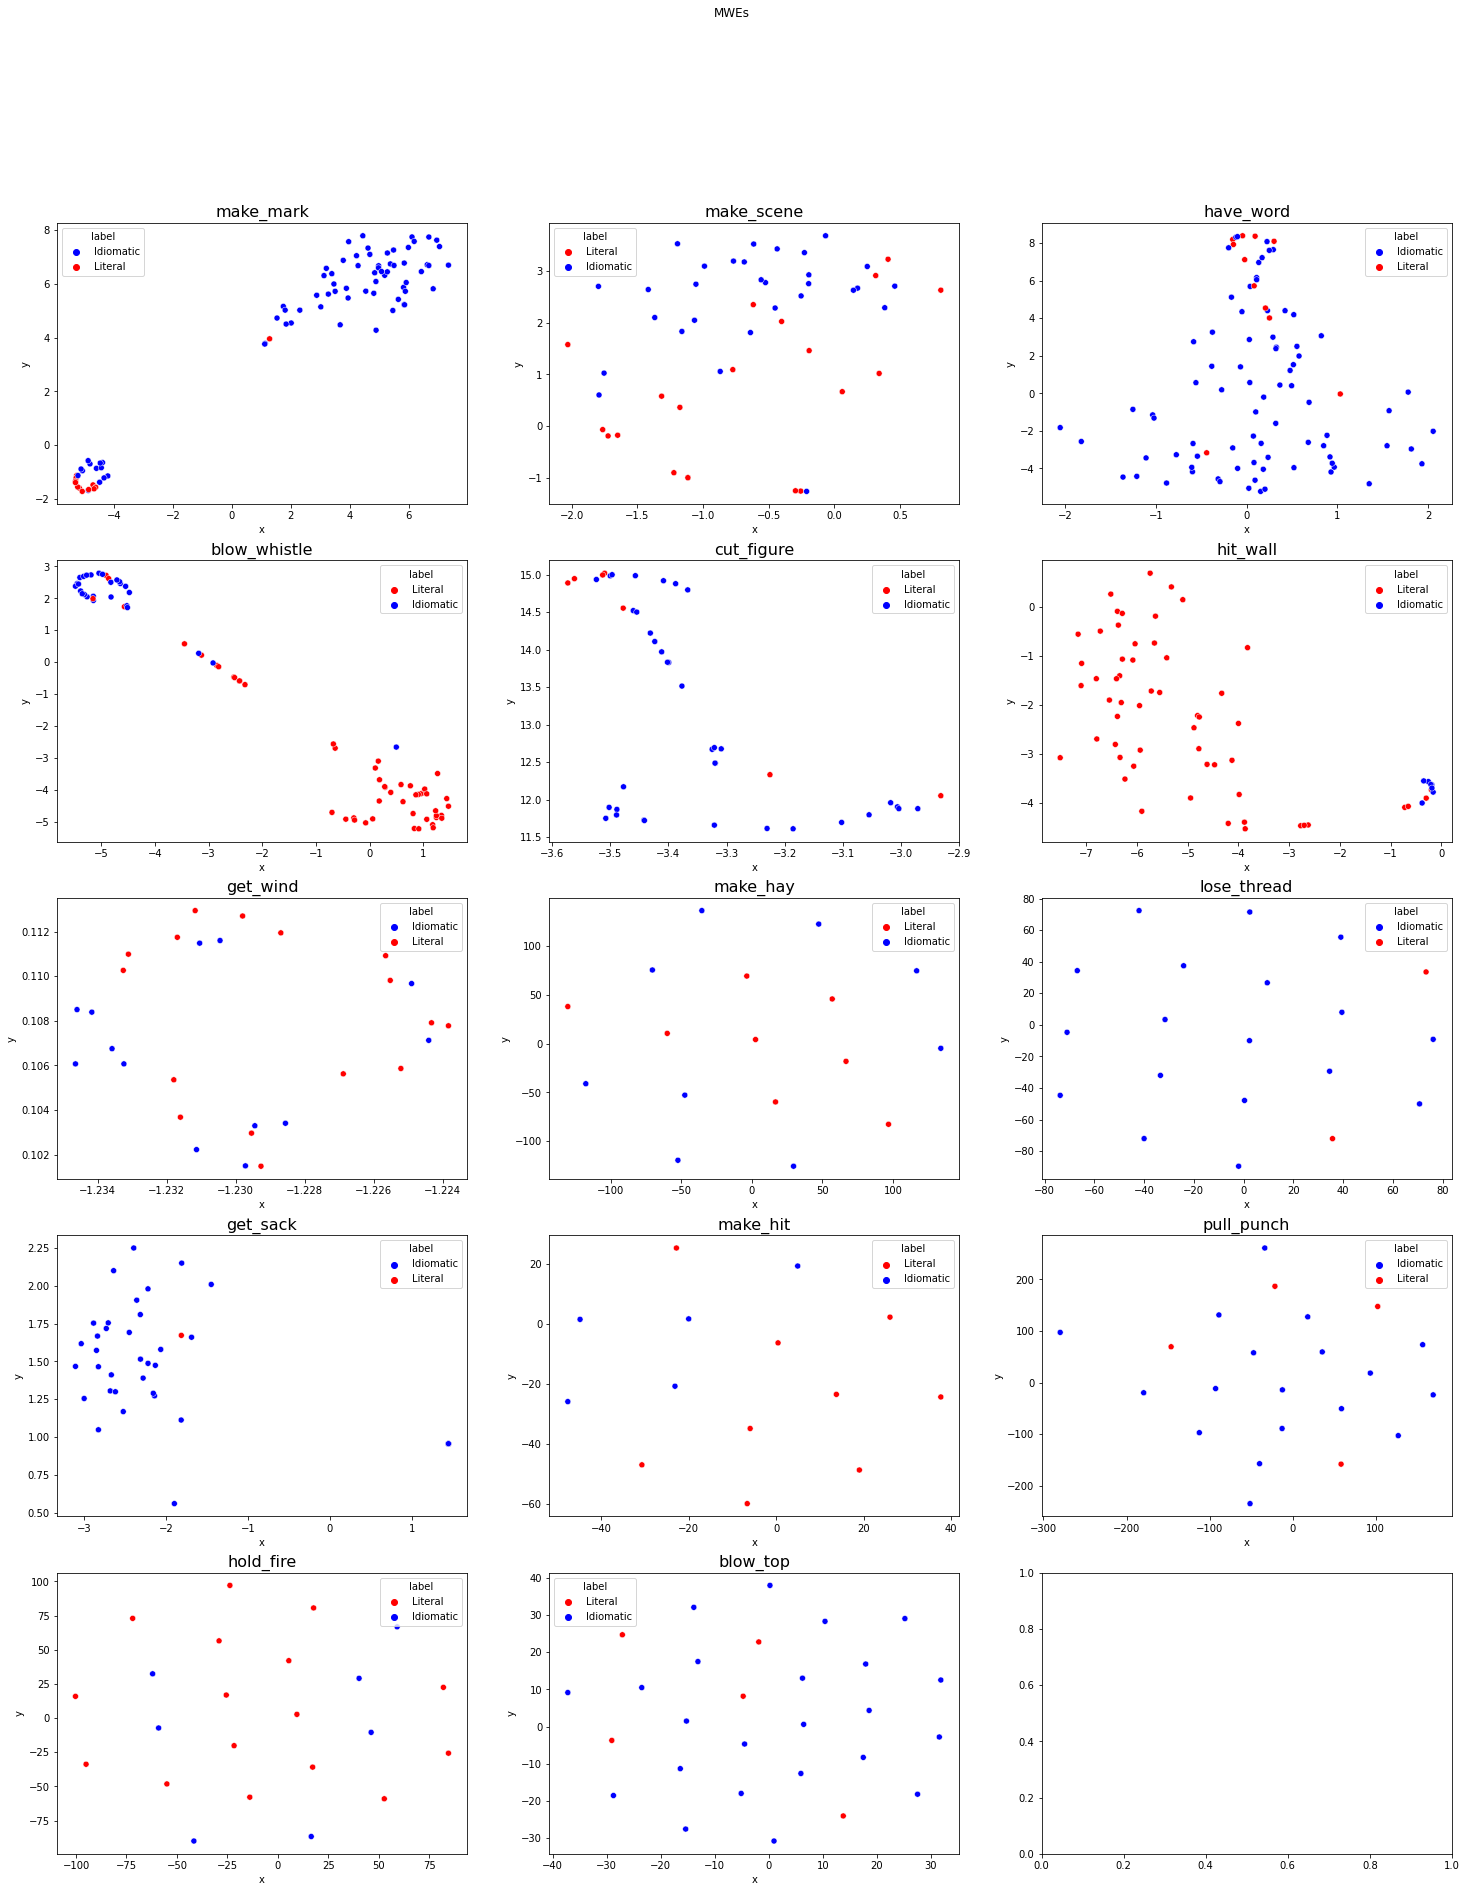

In [24]:
from sklearn.manifold import TSNE
fig, axes = plt.subplots(5, 3,figsize=(25,30))
fig.suptitle('MWEs')
i=0
df=pd.DataFrame()
temp_all['label'] = dev_all.label.map({0:'Literal', 1:'Idiomatic'})
t= TSNE(learning_rate=50)
mwe_list=temp_all.mwe.unique()
palette ={"Idiomatic": "blue", "Literal": "red"}
for m,ax in zip(mwe_list,axes.flatten()[:15]):
    df=pd.DataFrame()
    df['label']=temp_all[temp_all.mwe==m]['label']
    tsne_features=t.fit_transform(hidden_data[i])
    df['x']=tsne_features[:,0]
    df['y']=tsne_features[:,1]
    sns.scatterplot(ax=ax, x="x",y="y",hue='label',data=df,palette=palette).set_title(m,fontsize=16)
    i+=1
plt.show()

Text(0.5, 1.0, 'AllData')

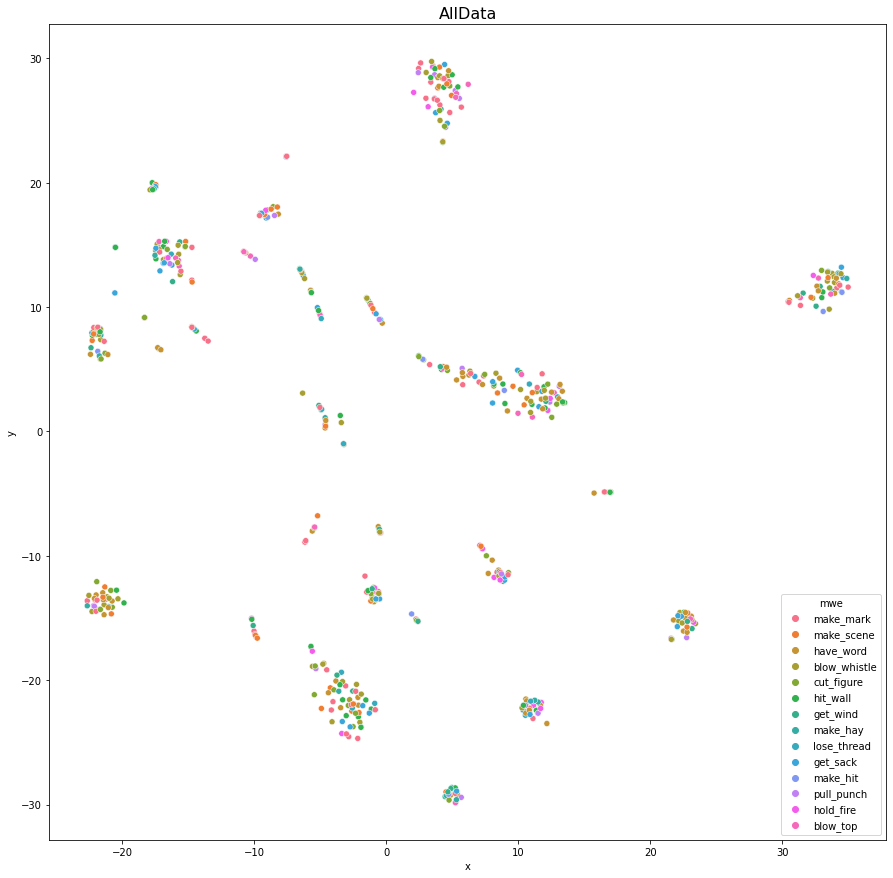

In [25]:
from sklearn.manifold import TSNE
all_hidden_data=[]
for i in range(0,14):
    for j in range(len(hidden_data[i])):
        all_hidden_data.append(hidden_data[i][j].tolist())

fig, axes = plt.subplots(1, 1,figsize=(15,15))
t= TSNE(learning_rate=50)
mwe_list=temp_all.mwe.unique()
df=pd.DataFrame()
df['label']=temp_all['label']
df['mwe']=temp_all['mwe']

tsne_features=t.fit_transform(all_hidden_data)
df['x']=tsne_features[:,0]
df['y']=tsne_features[:,1]
sns.scatterplot(ax= axes,x="x",y="y",hue='mwe',data=df).set_title('AllData',fontsize=16)

Text(0.5, 1.0, 'AllData')

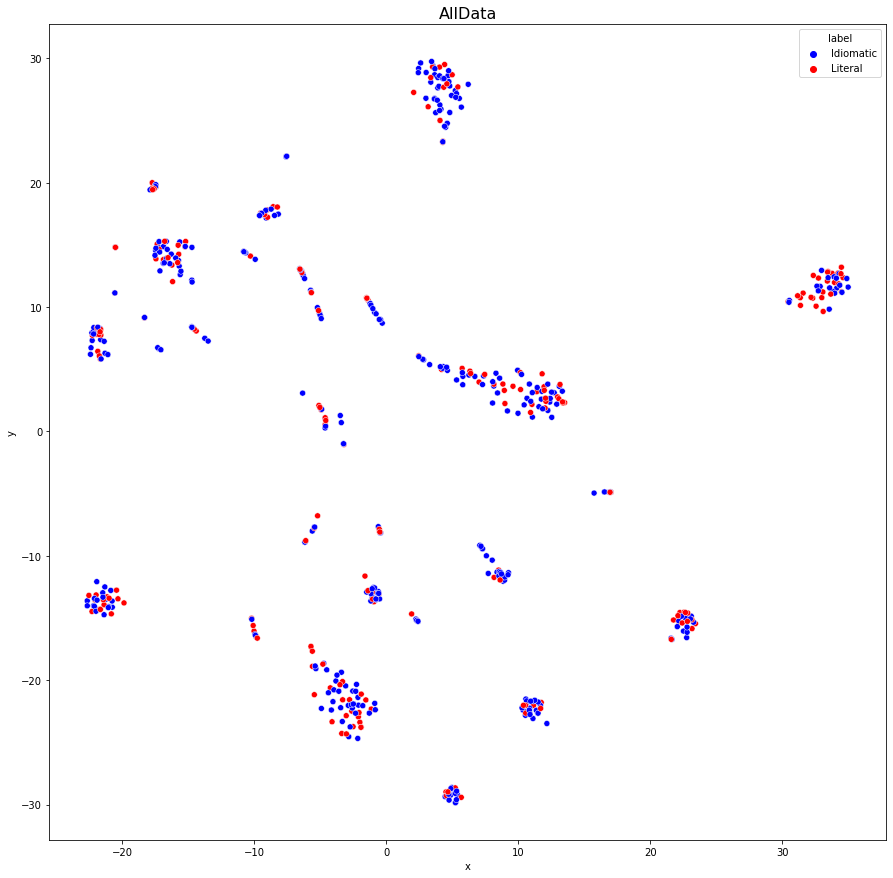

In [26]:
from sklearn.manifold import TSNE
# all_hidden_data=[]
# for i in range(0,14):
#     for j in range(len(hidden_data[i])):
#         all_hidden_data.append(hidden_data[i][j].tolist())
fig, axes = plt.subplots(1, 1,figsize=(15,15))
# t= TSNE(learning_rate=50)
# mwe_list=temp_all.mwe.unique()
palette ={"Idiomatic": "blue", "Literal": "red"}
# df=pd.DataFrame()
# df['label']=temp_all['label']
# tsne_features=t.fit_transform(all_hidden_data)
# df['x']=tsne_features[:,0]
# df['y']=tsne_features[:,1]
sns.scatterplot(ax= axes,x="x",y="y",hue='label',data=df,palette=palette).set_title('AllData',fontsize=16)

In [27]:
# dev_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Train.csv')
# dev_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/DEV-Test.csv')
# test_train=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Train.csv')
# test_test=pd.read_csv('./drive/My Drive/Colab Notebooks/dataset/TEST-Test.csv')
# dev_train=test_train
# dev_test=test_test
# dev_all=dev_train.append(dev_test)
# dev_all=dev_all[dev_all.fileName==0]
# dev_all['label'] = dev_all.label.map({'L':0, 'I':1})
# temp_all=dev_all


# from sklearn.manifold import TSNE
# fig, axes = plt.subplots(5, 3,figsize=(25,30))
# fig.suptitle('MWEs')
# i=0
# df=pd.DataFrame()
# temp_all['label'] = dev_all.label.map({0:'Literal', 1:'Idiomatic'})
# t= TSNE(learning_rate=50)
# mwe_list=temp_all.mwe.unique()
# palette ={"Idiomatic": "blue", "Literal": "red"}
# for m,ax in zip(mwe_list,axes.flatten()[:15]):
#     df=pd.DataFrame()
#     df['label']=temp_all[temp_all.mwe==m]['label']
#     tsne_features=t.fit_transform(cls_hs_input[i])
#     df['x']=tsne_features[:,0]
#     df['y']=tsne_features[:,1]
#     sns.scatterplot(ax=ax, x="x",y="y",hue='label',data=df,palette=palette).set_title(m,fontsize=16)
#     i+=1
# plt.show()

# all_hidden_data=[]
# for i in range(0,14):
#     for j in range(len(cls_hs_input[i])):
#         all_hidden_data.append(cls_hs_input[i][j].tolist())

# fig, axes = plt.subplots(1, 1,figsize=(15,15))
# t= TSNE(learning_rate=50)
# mwe_list=temp_all.mwe.unique()
# df=pd.DataFrame()
# df['label']=temp_all['label']
# df['mwe']=temp_all['mwe']

# tsne_features=t.fit_transform(all_hidden_data)
# df['x']=tsne_features[:,0]
# df['y']=tsne_features[:,1]
# sns.scatterplot(ax= axes,x="x",y="y",hue='mwe',data=df).set_title('AllData',fontsize=16)

# all_hidden_data=[]
# for i in range(0,14):
#     for j in range(len(cls_hs_input[i])):
#         all_hidden_data.append(cls_hs_input[i][j].tolist())
# fig, axes = plt.subplots(1, 1,figsize=(15,15))
# t= TSNE(learning_rate=50)
# mwe_list=temp_all.mwe.unique()
# palette ={"Idiomatic": "blue", "Literal": "red"}
# df=pd.DataFrame()
# df['label']=temp_all['label']
# tsne_features=t.fit_transform(all_hidden_data)
# df['x']=tsne_features[:,0]
# df['y']=tsne_features[:,1]
# sns.scatterplot(ax= axes,x="x",y="y",hue='label',data=df,palette=palette).set_title('AllData',fontsize=16)

Text(0.5, 1.0, 'AllData')

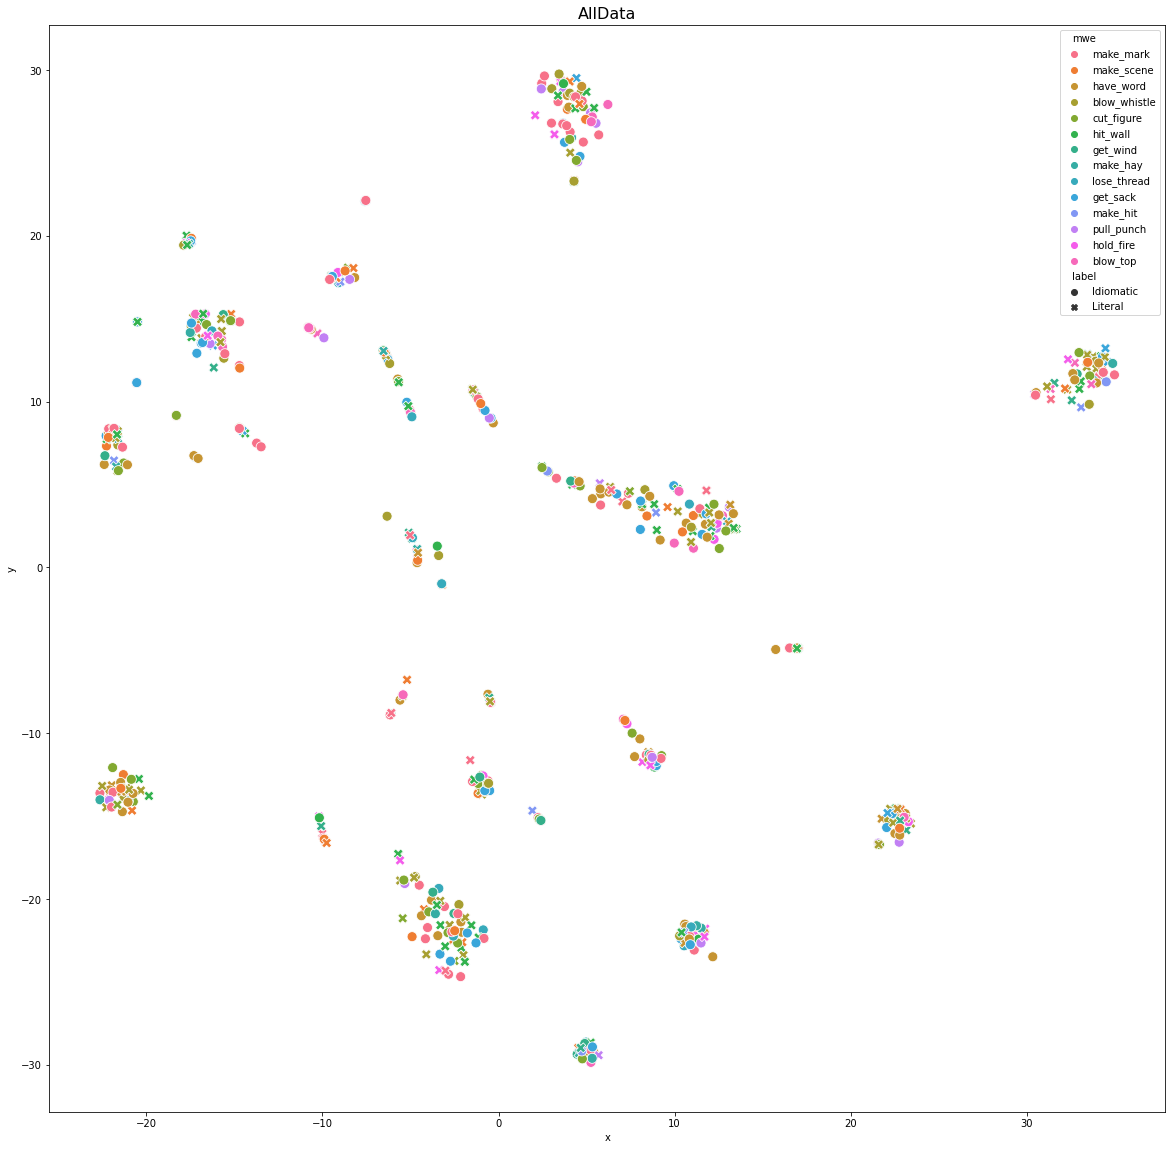

In [28]:
fig, axes = plt.subplots(1, 1,figsize=(20,20))
sns.scatterplot(ax= axes,x="x",y="y",hue='mwe',data=df,style='label',s=100).set_title('AllData',fontsize=16)